In [1]:
# Import TDCSophiread and analysis libraries
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Import TDCSophiread
import tdcsophiread as tdc

print(f"TDCSophiread version: {tdc.__version__}")
print(f"Numpy version: {np.__version__}")

# Setup plotting
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 12

TDCSophiread version: 3.0.2
Numpy version: 2.3.1


In [ ]:
data_file = "/SNS/VENUS/IPTS-35945/images/tpx3/raw/radiography/20250824_Thick_Cu_SlitO_40cm_2_500C_1_800AngsMin/20250824_Run_10586_Thick_Cu_SlitO_40cm_2_500C_1_800AngsMin_1/20250824_Run_10586_Thick_Cu_SlitO_40cm_2_500C_1_800AngsMin_1_000000.tpx3"

if os.path.exists(data_file):
    print(f"✓ Found: {data_file}")
    print(f"  Size: {os.path.getsize(data_file) / (1024*1024):.2f} MB")

✓ Found: /SNS/VENUS/IPTS-35945/images/tpx3/raw/radiography/20250824_Thick_Cu_SlitO_40cm_2_500C_1_800AngsMin/20250824_Run_10586_Thick_Cu_SlitO_40cm_2_500C_1_800AngsMin_1/20250824_Run_10586_Thick_Cu_SlitO_40cm_2_500C_1_800AngsMin_1_000000.tpx3
  Size: 41892.17 MB


In [ ]:
print("⏳ Processing TPX3 file... This may take a minute for large files")
print(f"   File size: {os.path.getsize(data_file) / (1024**3):.1f} GB")
# Start timing
start_time = time.time()
hits_view = tdc.process_tpx3(data_file, parallel=True)
# End timing
processing_time = time.time() - start_time

# Convert to numpy array (zero-copy)
hits = np.array(hits_view, copy=False)

# Display results
print(f"\nProcessing completed in {processing_time:.2f} seconds")
print(f"Total hits extracted: {len(hits):,}")

# Basic statistics
print("\nBasic Statistics:")
print(f"X range: {hits['x'].min()} - {hits['x'].max()}")
print(f"Y range: {hits['y'].min()} - {hits['y'].max()}")
print(
    f"TOF range: {hits['tof'].min() * 25 / 1e6:.3f} - {hits['tof'].max() * 25 / 1e6:.3f} ms"
)

# Chip distribution
unique_chips, chip_counts = np.unique(hits["chip_id"], return_counts=True)
print("\nHits per chip:")
for chip, count in zip(unique_chips, chip_counts):
    percentage = 100 * count / len(hits)
    print(f"  Chip {chip}: {count:,} hits ({percentage:.1f}%)")


Processing completed in 66.61 seconds
Total hits extracted: 5,475,501,557

Basic Statistics:
X range: 0 - 513
Y range: 0 - 513
TOF range: 0.000 - 16.666 ms

Hits per chip:
  Chip 0: 1,323,488,982 hits (24.2%)
  Chip 1: 1,240,677,625 hits (22.7%)
  Chip 2: 1,409,012,951 hits (25.7%)
  Chip 3: 1,502,321,999 hits (27.4%)


Generating 2D hit map ...
Using 54,755,015 sampled hits (1.0%) for visualization
Using 54,755,015 sampled hits (1.0%) for visualization


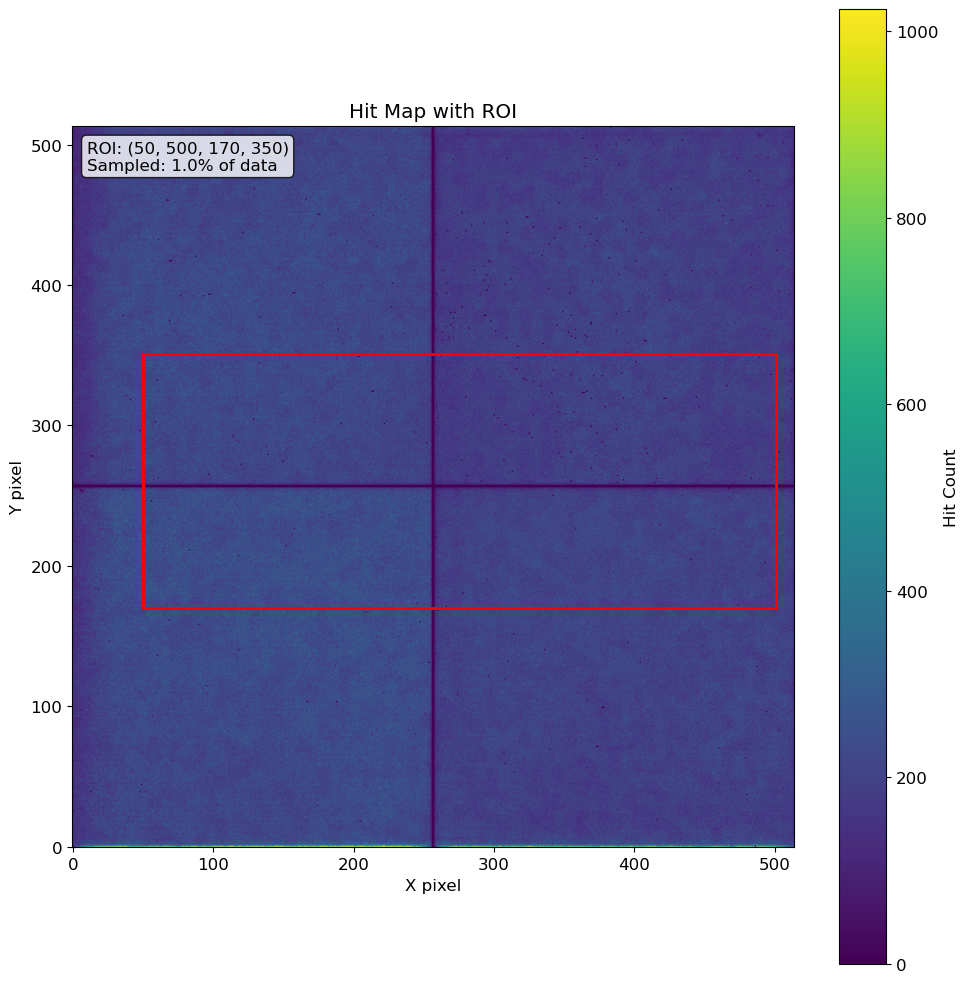

In [5]:
# Generate 2D histogram from hits with optional sampling for large datasets
print("Generating 2D hit map ...")

# Configuration for large dataset handling
use_sampling = True  # Set to False to use full dataset
sample_fraction = 0.01  # Use 1% of the data for visualization

# Apply sampling if enabled and dataset is large
if use_sampling and len(hits) > 100_000:  # Only sample for large datasets
    n_sample = int(len(hits) * sample_fraction)
    sample_indices = np.random.choice(len(hits), size=n_sample, replace=False)
    hits_for_viz = hits[sample_indices]
    print(f"Using {n_sample:,} sampled hits ({sample_fraction*100:.1f}%) for visualization")
else:
    hits_for_viz = hits
    print(f"Using all {len(hits):,} hits for visualization")

# Create 2D histogram (bin by detector pixels)
x_bins = np.arange(0, 515, 1)  # 0 to 514 pixels
y_bins = np.arange(0, 515, 1)  # 0 to 514 pixels

hist2d, x_edges, y_edges = np.histogram2d(
    hits_for_viz["x"], hits_for_viz["y"], bins=[x_bins, y_bins]
)

# Function to plot image with ROI overlay (matching reference notebook)
def plot_image_with_roi(image2d, roi, title="Hit Map with ROI"):
    """Display 2D image with ROI overlay"""
    x_low, x_high, y_low, y_high = roi
    width = x_high - x_low + 1
    height = y_high - y_low + 1

    fig, ax = plt.subplots(figsize=(10, 10))

    # Display image
    im = ax.imshow(image2d.T, origin="lower", cmap="viridis", aspect="equal")

    # Add ROI rectangle
    rect = Rectangle(
        (x_low, y_low), width, height, linewidth=2, edgecolor="red", facecolor="none"
    )
    ax.add_patch(rect)

    # Labels and title
    ax.set_xlabel("X pixel")
    ax.set_ylabel("Y pixel")
    ax.set_title(title)

    # Colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Hit Count")

    # Show ROI info and sampling info
    info_text = f"ROI: {roi}"
    if use_sampling and len(hits) > 100000:
        info_text += f"\nSampled: {sample_fraction*100:.1f}% of data"
    
    ax.text(
        0.02,
        0.98,
        info_text,
        transform=ax.transAxes,
        verticalalignment="top",
        bbox=dict(boxstyle="round", alpha=0.8, facecolor="white"),
    )

    plt.tight_layout()
    plt.show()

    return fig

# Define ROI (same as reference notebook)
roi = (50, 500, 170, 350)  # (x_low, x_high, y_low, y_high)
_ = plot_image_with_roi(hist2d, roi, title="Hit Map with ROI")

Using full dataset for TOF spectrum analysis (accuracy is critical)
ROI contains 1,688,194,778 hits from full dataset

TOF Spectrum Statistics:
Total counts in spectrum: 1,688,194,778
Peak count: 1,993,213
TOF range: 0.000 - 16.666 ms


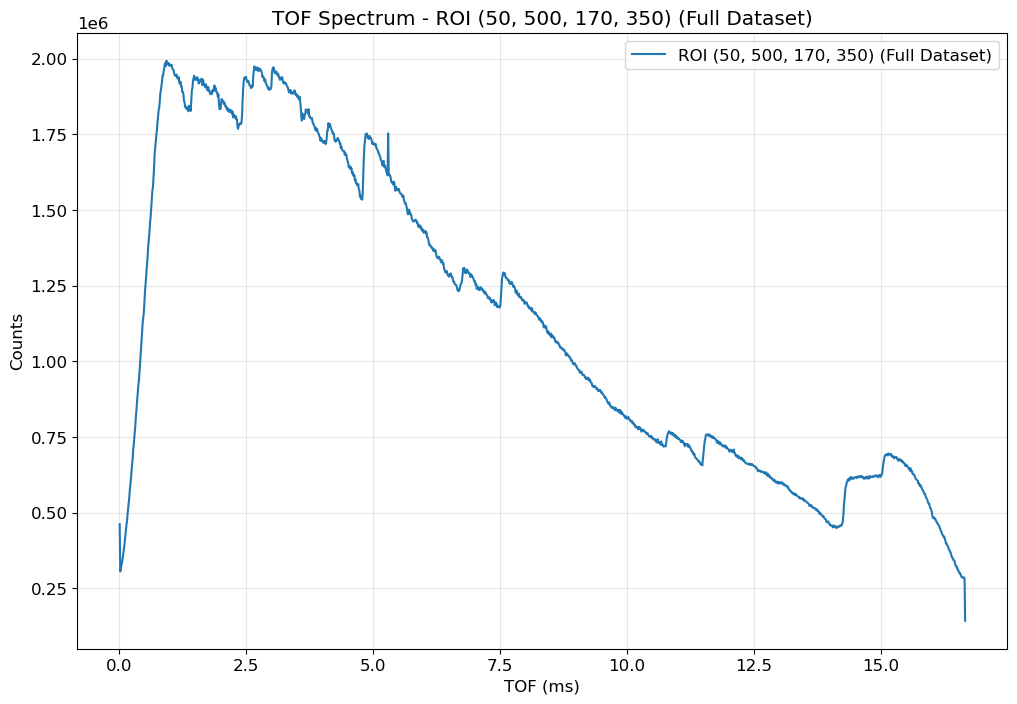

In [6]:
# Function to select ROI hits
def select_roi_hits(hits, roi):
    """Select hits within rectangular ROI"""
    x_low, x_high, y_low, y_high = roi
    x_mask = (hits["x"] >= x_low) & (hits["x"] <= x_high)
    y_mask = (hits["y"] >= y_low) & (hits["y"] <= y_high)
    roi_mask = x_mask & y_mask

    # Apply mask to get ROI hits
    return hits[roi_mask]


# TOF spectrum configuration
# Always use full dataset for TOF analysis to ensure maximum accuracy
print("Using full dataset for TOF spectrum analysis (accuracy is critical)")
num_tof_bins = 1500
tof_range_ms = (0, 1000 / 60.0)  # 0 to 1/60 seconds converted to milliseconds

# Select ROI hits from full dataset
roi_hits = select_roi_hits(hits, roi)
print(f"ROI contains {len(roi_hits):,} hits from full dataset")

# Convert TOF from TDC units to milliseconds (based on 25ns TDC resolution)
roi_tof_ms = roi_hits["tof"] * 25 / 1e6  # Convert to milliseconds

# Create histogram bins in milliseconds
bin_edges_ms = np.linspace(tof_range_ms[0], tof_range_ms[1], num_tof_bins + 1)
bin_centers_ms = (bin_edges_ms[:-1] + bin_edges_ms[1:]) / 2

# Create TOF spectrum
tof_spectrum, _ = np.histogram(roi_tof_ms, bins=bin_edges_ms)

# Plot TOF spectrum
plt.figure(figsize=(12, 8))
plt.plot(bin_centers_ms, tof_spectrum, label=f'ROI {roi} (Full Dataset)')
plt.xlabel("TOF (ms)")
plt.ylabel("Counts")
plt.title(f"TOF Spectrum - ROI {roi} (Full Dataset)")
plt.legend()
plt.grid(True, alpha=0.3)

# Print some statistics
print(f"\nTOF Spectrum Statistics:")
print(f"Total counts in spectrum: {np.sum(tof_spectrum):,}")
print(f"Peak count: {np.max(tof_spectrum):,}")
print(f"TOF range: {np.min(roi_tof_ms):.3f} - {np.max(roi_tof_ms):.3f} ms")
plt.show()

In [7]:
# Export TOF spectrum to CSV file
import pandas as pd
from datetime import datetime

# Create a meaningful filename based on the original data file and ROI
base_filename = os.path.basename(data_file).replace('.tpx3', '')
roi_str = f"ROI_{roi[0]}_{roi[1]}_{roi[2]}_{roi[3]}"
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_filename = f"{base_filename}_{roi_str}_TOF_spectrum_{timestamp}.csv"

# Create DataFrame with TOF data
tof_data = pd.DataFrame({
    'TOF_ms': bin_centers_ms,
    'Counts': tof_spectrum,
    'Bin_Width_ms': np.diff(bin_edges_ms)[0]  # All bins have same width
})

# Add metadata as comments in the CSV (using a header)
metadata = [
    f"# TOF Spectrum Export",
    f"# Original file: {data_file}",
    f"# ROI: {roi} (x_low, x_high, y_low, y_high)",
    f"# Total hits in ROI: {len(roi_hits):,}",
    f"# Number of TOF bins: {num_tof_bins}",
    f"# TOF range: {tof_range_ms[0]:.3f} - {tof_range_ms[1]:.3f} ms",
    f"# TDC resolution: 25 ns",
    f"# Export timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}",
    f"# Total spectrum counts: {np.sum(tof_spectrum):,}",
    f"# Peak count: {np.max(tof_spectrum):,}",
    f"#"
]

# Write metadata and data to CSV
with open(csv_filename, 'w') as f:
    # Write metadata as comments
    for line in metadata:
        f.write(line + '\n')
    
# Append the actual data
tof_data.to_csv(csv_filename, mode='a', index=False)

print(f"TOF spectrum exported to: {csv_filename}")
print(f"File contains {len(tof_data)} data points")
print(f"Columns: {list(tof_data.columns)}")

# Show first few rows as verification
print("\nFirst 5 rows of exported data:")
print(tof_data.head())

TOF spectrum exported to: 20250824_Run_10586_Thick_Cu_SlitO_40cm_2_500C_1_800AngsMin_1_000000_ROI_50_500_170_350_TOF_spectrum_20250825_214712.csv
File contains 1500 data points
Columns: ['TOF_ms', 'Counts', 'Bin_Width_ms']

First 5 rows of exported data:
     TOF_ms  Counts  Bin_Width_ms
0  0.005556  461865      0.011111
1  0.016667  305382      0.011111
2  0.027778  313625      0.011111
3  0.038889  324882      0.011111
4  0.050000  333780      0.011111
